In [43]:
# !pip install tensorflow


In [44]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[2]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [45]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
#nlp = spacy.load("en_core_web_sm")
from nltk import word_tokenize
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vector_functions import vectorize_word2vec, vectorize_glove
import nltk

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.utils import to_categorical



#### Beladung der Daten

In [46]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/train_cleaned.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
df_cleaned.head(1)

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,cinema award final rehearsal gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN


### Vektorisierung

#### GloVe 

In [75]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.twitter.27B.100d.txt'))


X_train_vectors, X_test_vectors, y_train, y_test, glove_embeddings = vectorize_glove(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)




c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


array([[[-0.28044   ,  0.39199999,  0.55759001, ...,  0.18381   ,
          0.094007  , -0.27184999],
        [-0.45910999, -0.58897001,  0.099599  , ...,  0.12999   ,
         -0.48536   , -0.31015   ],
        [-0.86185998, -0.94414997, -0.22002   , ..., -0.40002   ,
         -0.55721998,  0.74204999],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.039898  ,  0.90736002,  0.32747   , ...,  0.36886001,
          0.17496   , -0.58892   ],
        [ 0.45849001,  0.14165001,  0.0083564 , ...,  0.47777   ,
          0.21673   ,  0.16425   ],
        [-0.037545  ,  0.11898   ,  0.26445001, ...,  0.018283  ,
          0.004319  ,  0.11362   ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

### Reshaping für LSTM

In [76]:
print(X_train_vectors.shape)
print(X_test_vectors.shape)


(14124, 50, 100)
(6054, 50, 100)


### Modell aufbauen 

##### Die Modelleingaben überprüfen

In [77]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors.shape)
print(len(np.unique(y_test)))

14124
50
100
2
(6054, 50, 100)
2


#### One-Hot-Encoding der Labels

In [79]:

y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##### Modellinitialisierung

In [82]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#####  Modell trainieren

In [83]:

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9264 - loss: 0.2438 - val_accuracy: 0.9526 - val_loss: 0.1445
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9442 - loss: 0.1528 - val_accuracy: 0.9557 - val_loss: 0.1265
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9484 - loss: 0.1408 - val_accuracy: 0.9493 - val_loss: 0.1281
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9549 - loss: 0.1258 - val_accuracy: 0.9569 - val_loss: 0.1267
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9557 - loss: 0.1222 - val_accuracy: 0.9574 - val_loss: 0.1202
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9522 - loss: 0.1377 - val_accuracy: 0.9623 - val_loss: 0.1149
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9643 - loss: 0.1017 - val_accuracy: 0.9609 - val_loss: 0.1138
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9655 - loss: 0.0955 - 

### Modell bewerten

In [84]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9532 - loss: 0.1289
Test Loss: 0.12572847306728363
Test Accuracy: 0.9540799260139465
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Predicted classes: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      5687
     Class 1       0.62      0.63      0.63       367

    accuracy                           0.95      6054
   macro avg       0.80      0.80      0.80      6054
weighted avg       0.95      0.95      0.95      6054



[[5543  144]
 [ 134  233]]


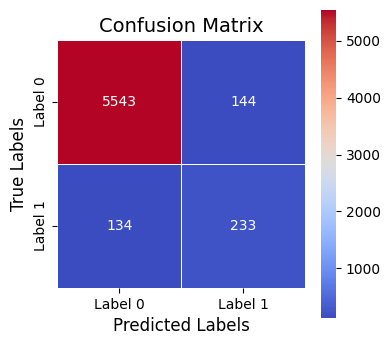

In [85]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Vektor word2w

In [86]:

X_train_w2v, X_test_w2v, y_train_wv, y_test_vw, w2v_model = vectorize_word2vec(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

print("Erste Trainingsvektoren:")
print(X_train_w2v[:2])

c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


Erste Trainingsvektoren:
[[[-0.27888492  0.5819779   0.2443881  ... -0.75722516  0.46862516
    0.11058311]
  [-0.18352988  0.54089183  0.17556599 ... -0.47685972  0.3112987
    0.02867597]
  [-0.07857565  0.17251287  0.05716551 ... -0.16432215  0.11620443
   -0.01011589]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.3756468   0.62409937  0.23890705 ... -0.72366869  0.57139605
   -0.23332888]
  [-0.08545966  0.22962178  0.08585239 ... -0.26212591  0.15215765
   -0.00882063]
  [-0.20757639  0.48471469  0.26644999 ... -0.54785693  0.51048237
   -0.14097542]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]


In [87]:
print(X_train_w2v.shape)
print(X_test_w2v.shape)
samples,max_seq_len, vector_size = X_train_w2v.shape
num_classes_vw = len(np.unique(y_train_wv))
y_train_onehot_w2v = to_categorical(y_train_wv, num_classes=num_classes)
y_test_onehot_w2v= to_categorical(y_test_vw, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)


(14124, 50, 100)
(6054, 50, 100)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [88]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_w2v, y_train_onehot,
    validation_data=(X_test_w2v, y_test_onehot_w2v),
    epochs=10,
    batch_size=32,
    verbose=1
)

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9199 - loss: 0.2930 - val_accuracy: 0.9394 - val_loss: 0.2287
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9294 - loss: 0.2598 - val_accuracy: 0.9394 - val_loss: 0.2301
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9288 - loss: 0.2575 - val_accuracy: 0.9394 - val_loss: 0.2298
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9320 - loss: 0.2531 - val_accuracy: 0.9394 - val_loss: 0.2238
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9295 - loss: 0.2430 - val_accuracy: 0.9394 - val_loss: 0.1987
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9284 - loss: 0.2309 - val_accuracy: 0.9394 - val_loss: 0.1936
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9340 - loss: 0.2146 - val_accuracy: 0.9394 - val_loss: 0.1913
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9307 - loss: 0.2105 - 

190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9306 - loss: 0.1831
Test Loss: 0.18314142525196075
Test Accuracy: 0.9314503073692322
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Predicted classes: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
Actual classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      5687
     Class 1       0.35      0.16      0.22       367

    accuracy                           0.93      6054
   macro avg       0.65      0.57      0.59      6054
weighted avg       0.91      0.93      0.92      6054

[[5581  106]
 [ 309   58]]


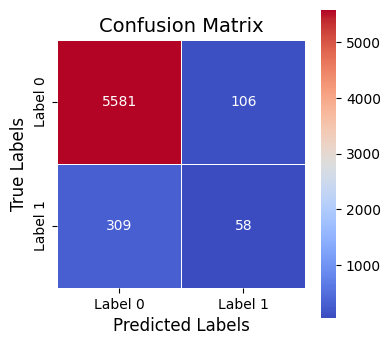

In [89]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_w2v, y_test_onehot_w2v)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_w2v)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot_w2v, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(np.argmax(y_test_onehot_w2v, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


#### Modeltraining mit anderen Parametern

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern, da diese für Binärklassifikation besser geeignet sein soll)

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9269 - loss: 0.2452 - val_accuracy: 0.9496 - val_loss: 0.1422
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9447 - loss: 0.1511 - val_accuracy: 0.9506 - val_loss: 0.1346
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9429 - loss: 0.1483 - val_accuracy: 0.8857 - val_loss: 0.1692
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9457 - loss: 0.1409 - val_accuracy: 0.9495 - val_loss: 0.1302
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9568 - loss: 0.1167 - val_accuracy: 0.9529 - val_loss: 0.1325
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9604 - loss: 0.1131 - val_accuracy: 0.9622 - val_loss: 0.1210
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9571 - loss: 0.1124 - val_accuracy: 0.9625 - val_loss: 0.1209
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9628 - loss: 0.0987 - 

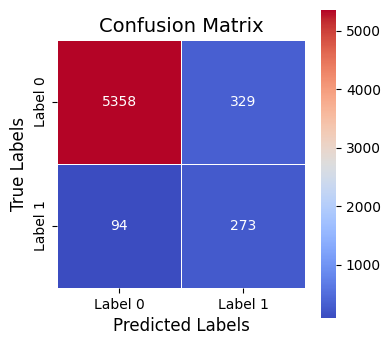

In [90]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

(units erhöht mit sigmoid)

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=256, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.9167 - loss: 0.2368 - val_accuracy: 0.9394 - val_loss: 0.2312
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9273 - loss: 0.2638 - val_accuracy: 0.9394 - val_loss: 0.2268
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9334 - loss: 0.2501 - val_accuracy: 0.9394 - val_loss: 0.2290
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.9324 - loss: 0.2519 - val_accuracy: 0.9394 - val_loss: 0.2300
Epoch 5/10
 12/442 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9383 - loss: 0.2340

#### Modeltraining mit anderen Parametern

(Dropout reduzieren mit sigmoid)

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.3))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

(Epochenerhöhung mit sigmoid)

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

Kombi

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=256, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.3))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_vectors, y_train_onehot,
    validation_data=(X_test_vectors, y_test_onehot),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))



# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()